In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, mev_quant

In [2]:
OBS_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [3]:
names, lats, lons, yys, yye, nys, Ns, Cs, Ws = [], [], [], [], [], [], [], [], []

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    # if ss >= 2001 and ny>=5: # Only station from 2001
    if ny>=10: # Only station with more than 10 years

        RAIN_xr = xr.DataArray(RAIN_pd['PRE'].values,  coords={'time':RAIN_pd['TIME'].values}, dims=('time'))

        RAIN_pd = RAIN_pd.dropna()

        RAIN_Wa = wei_fit_update(RAIN_pd['PRE'].values[RAIN_pd['PRE'].values>1])

        names.append(INFO_pd['File_Name'].values[nn])
        lats.append(INFO_pd['Lat'].values[nn])
        lons.append(INFO_pd['Lon'].values[nn])
        yys.append(ss)
        yye.append(ee)
        nys.append(ny)
        Ns.append(RAIN_Wa[0])
        Cs.append(RAIN_Wa[1])
        Ws.append(RAIN_Wa[2])

    else:
        pass

wa_pd = pd.DataFrame({'File_Name':names, 'Lat':lats, 'Lon':lons, 'YYS':yys, 'YYE':yye, 'NY':nys, 'N':Ns, 'C':Cs, 'W':Ws})

In [4]:
la_max, la_min, lo_max, lo_min = 45, 45.3, 12, 11.5

df_filtered = wa_pd[
    (wa_pd['Lat'] < la_min) & (wa_pd['Lat'] > la_max) &
    (wa_pd['Lon'] > lo_min) & (wa_pd['Lon'] < lo_max)

    ]

df_filtered = df_filtered.reset_index(drop=True)

In [5]:
Tr = np.array([5, 10, 20, 50, 70, 100, 150, 200, 500])
Fi = 1 - 1/Tr
x0 = 9.0*np.nanmean(df_filtered['C'].values)

OBS_Q = []
for ii in range(len(df_filtered)):
    QUANTILE, _ = mev_quant(Fi, x0, df_filtered['N'][ii],df_filtered['C'][ii],df_filtered['W'][ii], thresh=1)
    OBS_Q.append(QUANTILE)

OBS_Q_media = np.mean(np.array(OBS_Q), axis=0)

In [ ]:
df_in = f'../data/return_time/Veneto_IMERG.csv'
IMERG_df = pd.read_csv(df_in)

df_in = f'../data/return_time/Veneto_CMORPH.csv'
CMORPH_df = pd.read_csv(df_in)

df_in = f'../data/return_time/Veneto_MSWEP.csv'
MSWEP_df = pd.read_csv(df_in)

In [46]:
SATE_mean = (IMERG_df['SATE_MEAN'] + CMORPH_df['SATE_MEAN'] + MSWEP_df['SATE_MEAN'])/3
DOWN_mean = (IMERG_df['DOWN_MEAN'] + CMORPH_df['DOWN_MEAN'] + MSWEP_df['DOWN_MEAN'])/3

Text(0.0, 1.0, 'Veneto Gauge Network vs Downscale')

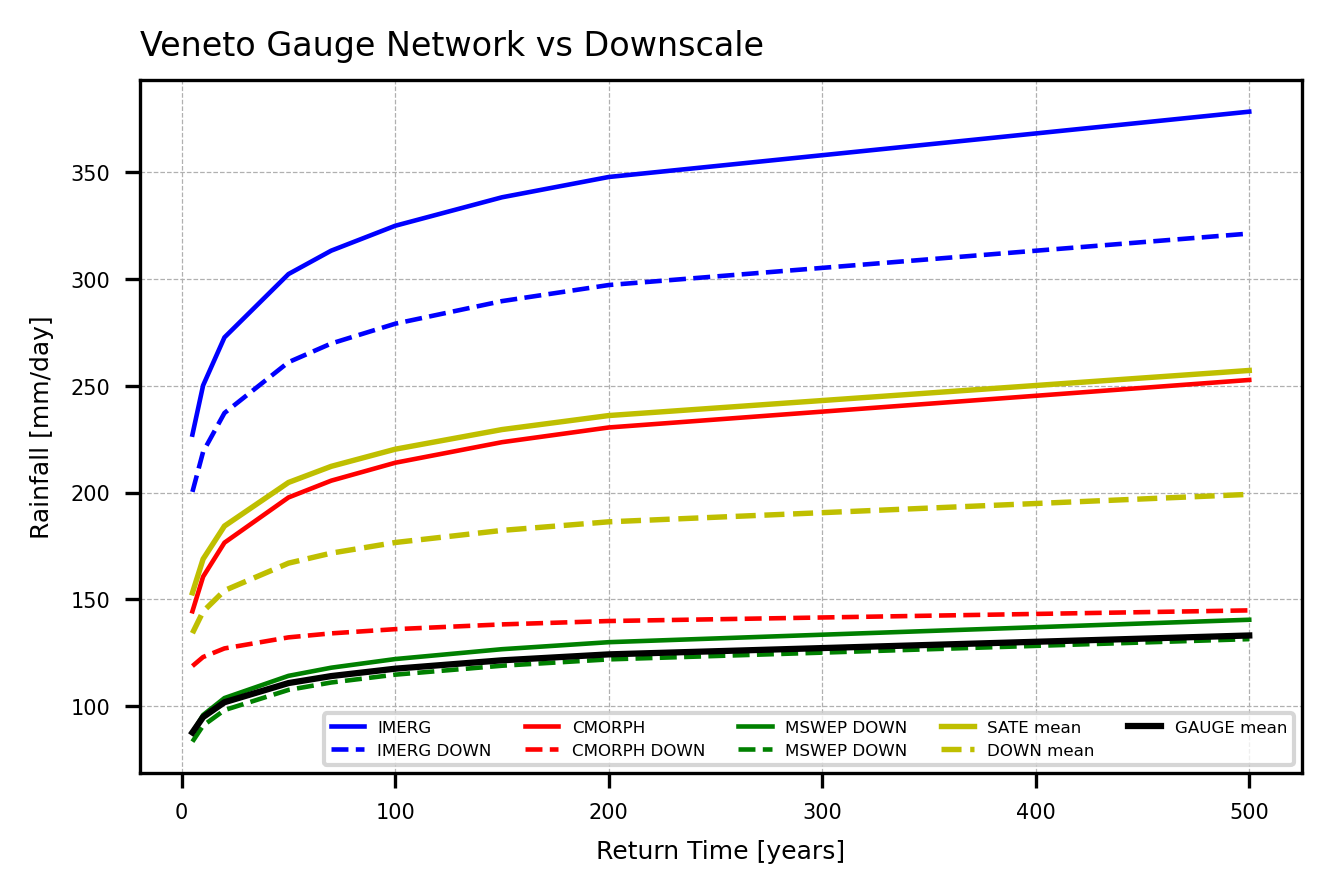

In [50]:
fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(Tr, IMERG_df['SATE_MEAN'], 'b-', linewidth=1.1, label='IMERG')
ax1.plot(Tr, IMERG_df['DOWN_MEAN'], 'b--', linewidth=1.1, label='IMERG DOWN')

ax1.plot(Tr, CMORPH_df['SATE_MEAN'], 'r-', linewidth=1.1, label='CMORPH')
ax1.plot(Tr, CMORPH_df['DOWN_MEAN'], 'r--',linewidth=1.1, label='CMORPH DOWN')

ax1.plot(Tr, MSWEP_df['SATE_MEAN'], 'g-', linewidth=1.1, label='MSWEP DOWN')
ax1.plot(Tr, MSWEP_df['DOWN_MEAN'], 'g--', linewidth=1.1, label='MSWEP DOWN')

ax1.plot(Tr, SATE_mean, 'y-', linewidth=1.3, label='SATE mean')
ax1.plot(Tr, DOWN_mean, 'y--', linewidth=1.3, label='DOWN mean')

ax1.plot(Tr, OBS_Q_media,'-k', linewidth=1.5, label='GAUGE mean')

plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=4, ncol=5)

ax1.set_xlabel('Return Time [years]', fontsize=6)
ax1.set_ylabel('Rainfall [mm/day]', fontsize=6)
ax1.set_title('Veneto Gauge Network vs Downscale', fontsize=8, loc='left')

In [27]:
df_in = f'../data/return_time/Veneto_IMERG_Beta_Gamma.csv'
IMERG_PARAM = pd.read_csv(df_in)

df_in = f'../data/return_time/Veneto_CMORPH_Beta_Gamma.csv'
CMORPH_PARAM = pd.read_csv(df_in)

df_in = f'../data/return_time/Veneto_MSWEP_Beta_Gamma.csv'
MSWEP_PARAM = pd.read_csv(df_in)

Text(0.0, 1.0, '(b) Gamma')

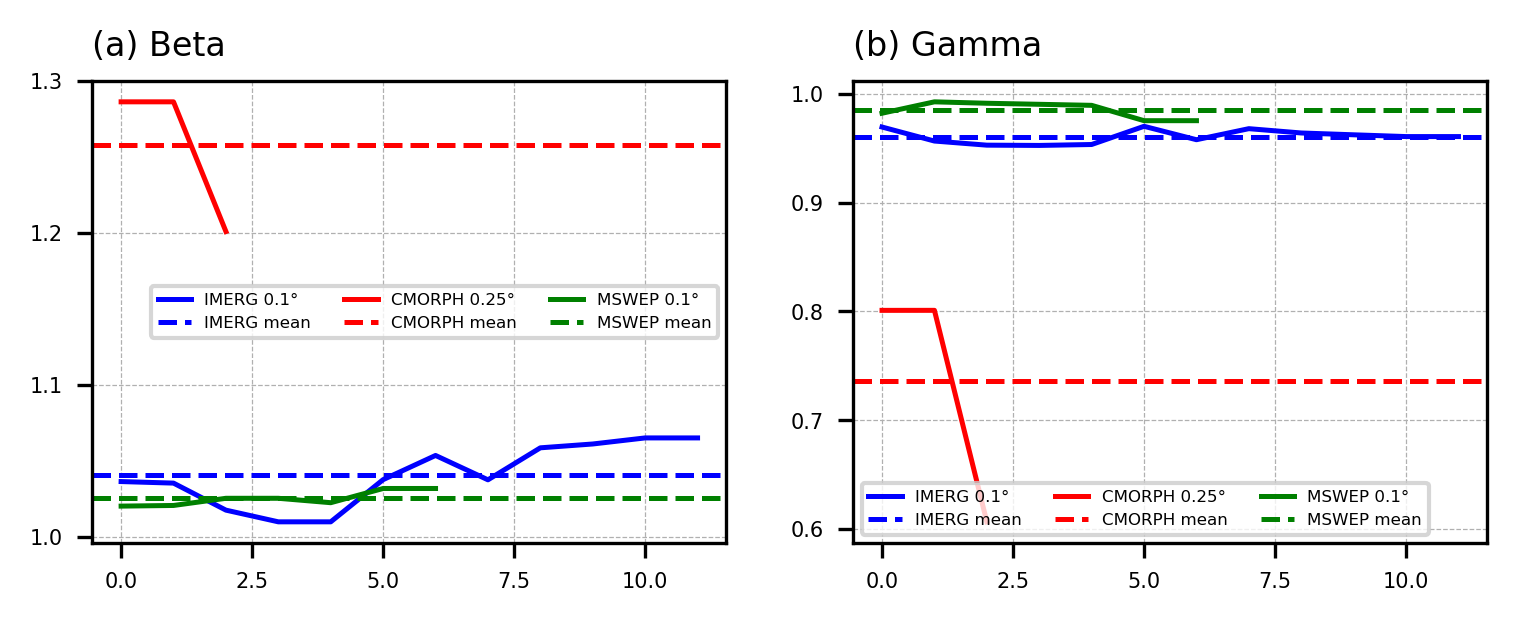

In [69]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(IMERG_PARAM['BETA'], '-b', linewidth=1.2, label='IMERG 0.1°')
ax1.axhline(np.mean(IMERG_PARAM['BETA']), color='b', linestyle='--', linewidth=1.2, label='IMERG mean')

ax1.plot(CMORPH_PARAM['BETA'], '-r', linewidth=1.2, label='CMORPH 0.25°')
ax1.axhline(np.mean(CMORPH_PARAM['BETA']), color='r', linestyle='--', linewidth=1.2, label='CMORPH mean')

ax1.plot(MSWEP_PARAM['BETA'], '-g', linewidth=1.2, label='MSWEP 0.1°')
ax1.axhline(np.mean(MSWEP_PARAM['BETA']), color='g', linestyle='--', linewidth=1.2, label='MSWEP mean')

plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=4, ncol=3)

ax1.set_title('(a) Beta', fontsize=8, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(IMERG_PARAM['GAMMA'], '-b', linewidth=1.2, label='IMERG 0.1°')
ax1.axhline(np.mean(IMERG_PARAM['GAMMA']), color='b', linestyle='--', linewidth=1.2, label='IMERG mean')

ax1.plot(CMORPH_PARAM['GAMMA'], '-r', linewidth=1.2, label='CMORPH 0.25°')
ax1.axhline(np.mean(CMORPH_PARAM['GAMMA']), color='r', linestyle='--', linewidth=1.2, label='CMORPH mean')

ax1.plot(MSWEP_PARAM['GAMMA'], '-g', linewidth=1.2, label='MSWEP 0.1°')
ax1.axhline(np.mean(MSWEP_PARAM['GAMMA']), color='g', linestyle='--', linewidth=1.2, label='MSWEP mean')

plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize=4, ncol=3)

ax1.set_title('(b) Gamma', fontsize=8, loc='left')